In [53]:
import kagglehub
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import string
import torch
import random
from torch.utils.data import Dataset
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import Counter
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

# Ngambil Dataset dari Kaggle

In [5]:
# Download latest version
path = kagglehub.dataset_download("niraliivaghani/chatbot-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chatbot-dataset


In [6]:
def json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

dataset_path = "/kaggle/input/chatbot-dataset"
filename = os.path.join(dataset_path, "intents.json")
intents = json_file(filename)

# EDA

In [7]:
print(intents.keys())

dict_keys(['intents'])


In [8]:
all_fields = set()
for intent in intents['intents']:
    all_fields.update(intent.keys())

for field in sorted(all_fields):
    print(f"  - {field}")

  - context_set
  - patterns
  - responses
  - tag


In [9]:
def create_df():
    df = pd.DataFrame({
        'pattern' : [],
        'tags' : [],
        'context_set' : []
    })
    return df

def extract_json(json_file, df):
    for intent in json_file['intents']:
        for i in intent['patterns']:
            context_set = intent.get('context_set', [])
            sentence_tag = [i, intent['tag'], context_set]
            df.loc[len(df.index)] = sentence_tag
    return df

df= create_df()
df = extract_json(intents, df)
df.head()

,pattern,tags,context_set
0,Hi,greeting,
1,How are you?,greeting,
2,Is anyone there?,greeting,
3,Hello,greeting,
4,Good day,greeting,


In [10]:
df.drop('context_set',axis='columns', inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, 0 to 404
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pattern  405 non-null    object
 1   tags     405 non-null    object
dtypes: object(2)
memory usage: 25.7+ KB


In [12]:
df.shape

(405, 2)

In [13]:
df.isna().sum()

,0
pattern,0
tags,0


In [14]:
tag_class_distribution = df['tags'].value_counts(normalize=True) * 100

print(f"Total classes : {df['tags'].nunique()}")
for tag, percentage in tag_class_distribution.items():
    print(f"{tag}: {percentage:.2f}%")

Total classes : 38
course: 6.67%
scholarship: 6.42%
fees: 5.68%
hostel: 5.43%
hours: 4.20%
creator: 3.95%
number: 3.70%
library: 3.46%
location: 3.46%
name: 3.21%
salutaion: 3.21%
document: 3.21%
vacation: 2.96%
goodbye: 2.96%
canteen: 2.72%
sem: 2.72%
event: 2.72%
greeting: 2.47%
ragging: 2.47%
placement: 2.22%
swear: 2.22%
uniform: 2.22%
college intake: 2.22%
sports: 1.73%
floors: 1.73%
principal: 1.73%
menu: 1.73%
syllabus: 1.73%
admission: 1.48%
committee: 1.48%
task: 1.48%
facilities: 1.23%
ithod: 0.99%
computerhod: 0.99%
extchod: 0.99%
infrastructure: 0.74%
random: 0.74%
hod: 0.74%


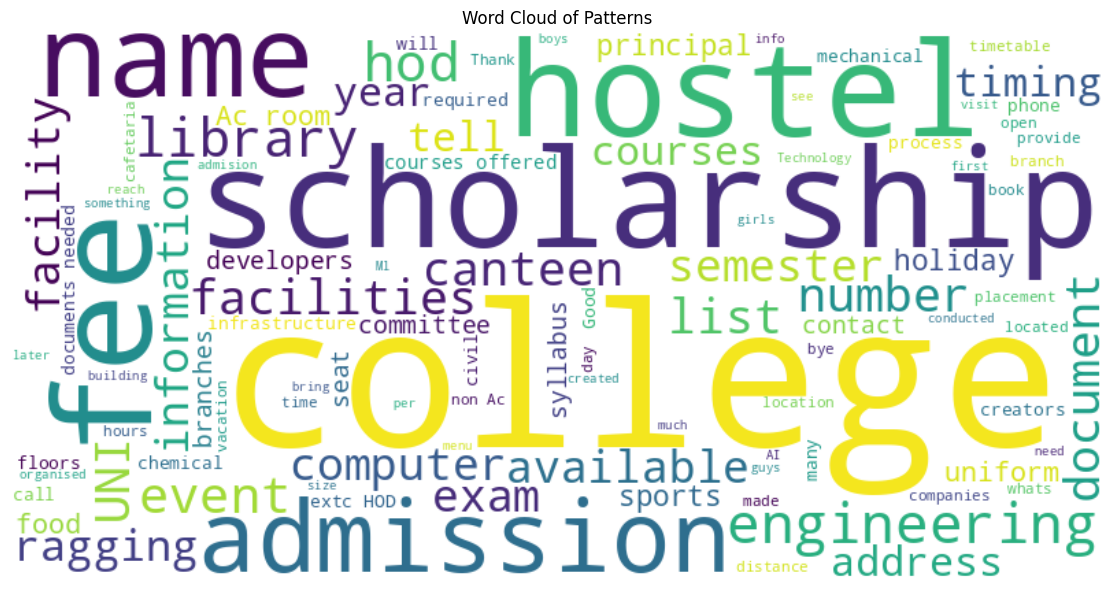

In [15]:
def plot_wordcloud(df):
    all_text = ' '.join(df['pattern'].astype(str))

    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100,
                         colormap='viridis').generate(all_text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Patterns')
    plt.tight_layout()
    plt.show()

plot_wordcloud(df)

In [16]:
def pattern_words(df):
    all_text = ' '.join(df['pattern'].astype(str))
    words = all_text.split()
    unique_words = set(words)

    print(f"Total words: {len(words)}")
    print(f"Unique words: {len(unique_words)}")
    print(f"Average words per pattern: {len(words)/len(df):.2f}")


    word_counts = Counter(words)
    print(f"Top 10 most common words:")
    for word, count in word_counts.most_common(10):
        print(f" {word}: {count}")

pattern_words(df)


Total words: 1340
Unique words: 334
Average words per pattern: 3.31
Top 10 most common words:
 is: 70
 college: 66
 the: 46
 what: 43
 you: 33
 of: 33
 in: 29
 for: 26
 scholarship: 25
 hostel: 24


# Data Preprocessing

In [17]:
df.head()

,pattern,tags
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [18]:
labels = df['tags'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['greeting',
 'goodbye',
 'creator',
 'name',
 'hours',
 'number',
 'course',
 'fees',
 'location',
 'hostel',
 'event',
 'document',
 'floors',
 'syllabus',
 'library',
 'infrastructure',
 'canteen',
 'menu',
 'placement',
 'ithod',
 'computerhod',
 'extchod',
 'principal',
 'sem',
 'admission',
 'scholarship',
 'facilities',
 'college intake',
 'uniform',
 'committee',
 'random',
 'swear',
 'vacation',
 'sports',
 'salutaion',
 'task',
 'ragging',
 'hod']

In [19]:
num_labels = len(labels)
idtolabel = {id:label for id, label in enumerate(labels)}
print(idtolabel)

{0: 'greeting', 1: 'goodbye', 2: 'creator', 3: 'name', 4: 'hours', 5: 'number', 6: 'course', 7: 'fees', 8: 'location', 9: 'hostel', 10: 'event', 11: 'document', 12: 'floors', 13: 'syllabus', 14: 'library', 15: 'infrastructure', 16: 'canteen', 17: 'menu', 18: 'placement', 19: 'ithod', 20: 'computerhod', 21: 'extchod', 22: 'principal', 23: 'sem', 24: 'admission', 25: 'scholarship', 26: 'facilities', 27: 'college intake', 28: 'uniform', 29: 'committee', 30: 'random', 31: 'swear', 32: 'vacation', 33: 'sports', 34: 'salutaion', 35: 'task', 36: 'ragging', 37: 'hod'}


In [20]:
labeltoid = {label:id for id, label in enumerate(labels)}
print(labeltoid)

{'greeting': 0, 'goodbye': 1, 'creator': 2, 'name': 3, 'hours': 4, 'number': 5, 'course': 6, 'fees': 7, 'location': 8, 'hostel': 9, 'event': 10, 'document': 11, 'floors': 12, 'syllabus': 13, 'library': 14, 'infrastructure': 15, 'canteen': 16, 'menu': 17, 'placement': 18, 'ithod': 19, 'computerhod': 20, 'extchod': 21, 'principal': 22, 'sem': 23, 'admission': 24, 'scholarship': 25, 'facilities': 26, 'college intake': 27, 'uniform': 28, 'committee': 29, 'random': 30, 'swear': 31, 'vacation': 32, 'sports': 33, 'salutaion': 34, 'task': 35, 'ragging': 36, 'hod': 37}


In [21]:
df['labels'] = df['tags'].map(lambda x: labeltoid[x.strip()])
df.head()

,pattern,tags,labels
0,Hi,greeting,0
1,How are you?,greeting,0
2,Is anyone there?,greeting,0
3,Hello,greeting,0
4,Good day,greeting,0


In [22]:
X = list(df['pattern'])
y = list(df['labels'])

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42)

# Load model and Train

In [24]:
device = 'cuda'

In [25]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=idtolabel,
    label2id=labeltoid
).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
train_encoding = tokenizer(
    X_train,
    truncation=True,
    padding='max_length',
    max_length=256,
)

test_encoding = tokenizer(
    X_test,
    truncation=True,
    padding='max_length',
    max_length=256,
)

In [27]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [28]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [36]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0
    )
    accuracy = accuracy_score(labels, preds)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [37]:
os.environ["WANDB_DISABLED"] = "true"

In [38]:
training_args = TrainingArguments(
    output_dir='./aol_nlp',
    do_train=True,
    do_eval=True,
    num_train_epochs=50,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    learning_rate = 3e-5,
    warmup_steps=50,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps = 100,
    load_best_model_at_end=True
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [39]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics
)

In [40]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.210300,0.556675,0.882353,0.823129,0.834722,0.847553
200,0.074900,0.536765,0.892157,0.824011,0.831944,0.854497
300,0.041600,0.533200,0.901961,0.867221,0.881944,0.882275
400,0.031000,0.529578,0.901961,0.861048,0.873611,0.882275
500,0.028300,0.531264,0.901961,0.861048,0.873611,0.882275


TrainOutput(global_step=500, training_loss=0.09743538594245911, metrics={'train_runtime': 815.2354, 'train_samples_per_second': 18.584, 'train_steps_per_second': 0.613, 'total_flos': 1993710462105600.0, 'train_loss': 0.09743538594245911, 'epoch': 50.0})

In [41]:
eva=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(eva, index=["train","test"]).iloc[:,:5]

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall
train,0.021373,1.000000,1.000000,1.000000,1.000000
test,0.529578,0.901961,0.861048,0.873611,0.882275


In [42]:
model_path = "chatbot_aol_nlp"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('chatbot_aol_nlp/tokenizer_config.json',
 'chatbot_aol_nlp/special_tokens_map.json',
 'chatbot_aol_nlp/vocab.txt',
 'chatbot_aol_nlp/added_tokens.json',
 'chatbot_aol_nlp/tokenizer.json')

In [43]:
import shutil
from google.colab import files

folder_to_download = 'chatbot_aol_nlp'
output_zip_filename = f'{folder_to_download}.zip'
folder_path = f'/content/{folder_to_download}'
shutil.make_archive(output_zip_filename.replace('.zip', ''), 'zip', folder_path)
files.download(output_zip_filename)

print(f"Zipped '{folder_path}' into '{output_zip_filename}' and initiated download.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Zipped '/content/chatbot_aol_nlp' into 'chatbot_aol_nlp.zip' and initiated download.


# nyoba"

In [52]:
model_path = "/content/chatbot_aol_nlp"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
chatbot("hello")

Device set to use cuda:0


[{'label': 'greeting', 'score': 0.9281367063522339}]

In [57]:
def chat(chatbot, labeltoid, intents):
    print("Welcome to University Chatbot!!")
    print("Type 'quit' to exit the chat\n")

    while True:
        text = input("User: ").strip()

        if text.lower() == 'quit':
            print("Chatbot: Goodbye!")
            break
        if text == "":
            print("Chatbot: Please type something!\n")
            continue

        predictions = chatbot(text)
        score = predictions[0]['score']

        if score < 0.8:
            print("Chatbot: Sorry, I can't answer that.\n")
            continue

        label = labeltoid[predictions[0]['label']]
        response = random.choice(intents['intents'][label]['responses'])

        print(f"Chatbot: {response}\n")


In [59]:
chat(chatbot, labeltoid, intents)

Welcome to University Chatbot!!
Type 'quit' to exit the chat

User: Hello
Chatbot: Hi there, how can I help?

User: where is the libraries??
Chatbot: There is one huge and spacious library.timings are 8am to 6pm and for more visit <a target="blank" href="ADD LIBRARY DETAIL LINK">here</a>

User: and how about the canteen
Chatbot: Our university has canteen with variety of food available

User: what sports do this university support?
Chatbot: Our university encourages all-round development of students and hence provides sports facilities in the campus. For more details visit<a target="_blank" href=/"(LINK IF HAVE)">here</a>

User: i want the information about the hostel
Chatbot: For hostel detail visit <a target="_blank" href="ADD YOUR HOSTEL DETAIL PDF LINK OR ANY INFORMATION LINK OR ADD YOU OWN ANSWERS"> here</a>

User: any info about scholarship?
Chatbot: Many government scholarships are supported by our university. For details and updates visit <a target="_blank" href="(SCHOLARSHIP D